In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

from torch.utils.data import Dataset, DataLoader

import xarray as xr
import numpy as np
import matplotlib.pyplot as plt
import copy
import os
from sklearn import metrics

In [2]:
gpu_id = 0

def set_gpu(gpu_id):
    os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID"
    os.environ["CUDA_VISIBLE_DEVICES"] = str(gpu_id)

if gpu_id >= 0:
    device = "cuda"
    set_gpu(gpu_id)
    print('device available :', torch.cuda.is_available())
    print('device count: ', torch.cuda.device_count())
    print('current device: ',torch.cuda.current_device())
    print('device name: ',torch.cuda.get_device_name())
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
else:
    device = torch.device('cpu')
        

device available : True
device count:  1
current device:  0
device name:  NVIDIA A100-SXM4-80GB


## CNN class

In [3]:
class CategoricalCNN(nn.Module):
    def __init__(self, input_shape, num_classes=9):
        """
        Initialize the CNN model.
        
        Parameters:
            input_shape (tuple): The shape of the input images (C, H, W).
            num_classes (int): The number of classes for prediction.
        """
        super(CategoricalCNN, self).__init__()
        
        self.conv1 = nn.Conv2d(in_channels=input_shape[0], out_channels=32, kernel_size=3, padding=1)
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)
        self.conv2 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, padding=1)
        
        # Calculate the size of the flattened features after conv and pooling layers
        self.flattened_size = 64 * (input_shape[1] // 4) * (input_shape[2] // 4)
        
        self.fc1 = nn.Linear(self.flattened_size, 128)
        self.fc2 = nn.Linear(128, num_classes)
        
    def forward(self, x):
        """
        Forward pass through the model.
        
        Parameters:
            x (torch.Tensor): Input tensor.
        
        Returns:
            torch.Tensor: The output of the network.
        """
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = x.view(-1, self.flattened_size)  # Flatten the tensor for the fully connected layer
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x

# Example usage
input_shape = (5, 32, 288)  # Example input shape (C, H, W)
model = CategoricalCNN(input_shape=input_shape, num_classes=9)
print(model)

# Example for a forward pass (dummy input)
# Create a dummy input tensor of the correct shape
dummy_input = torch.randn(1, *input_shape)  # Batch size of 1 for example
output = model(dummy_input)
print(output)

CategoricalCNN(
  (conv1): Conv2d(5, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (fc1): Linear(in_features=36864, out_features=128, bias=True)
  (fc2): Linear(in_features=128, out_features=9, bias=True)
)
tensor([[ 0.0427,  0.0793,  0.0058, -0.0546, -0.0197, -0.0127, -0.1660,  0.1157,
         -0.0588]], grad_fn=<AddmmBackward0>)


## Load the Data

In [4]:
DS = xr.open_dataset('./Classify_dataset_MJO.nc')
DS['U200']=DS['U'].sel(lev=200,method='nearest')
DS['V200']=DS['V'].sel(lev=200,method='nearest')
DS['U850']=DS['U'].sel(lev=850,method='nearest')
DS['V850']=DS['V'].sel(lev=850,method='nearest')
DS = DS.drop('U')
DS = DS.drop('V')
DStrain = DS.sel(time=slice('2000','2005'))
DSval = DS.sel(time=slice('2006','2006'))
DStest = DS.sel(time=slice('2007','2007'))
DStrainm = DStrain[['U200','U850','V200','V850','FLUTC']].mean(['time','lat','lon'])
DStrains = DStrain[['U200','U850','V200','V850','FLUTC']].std(['time','lat','lon'])


DStrain_norm = (DStrain - DStrainm)/DStrains
DSval_norm = (DSval - DStrainm)/DStrains
DStest_norm = (DStest - DStrainm)/DStrains
DStrain_norm_arr = np.array(DStrain_norm.to_array())
DStrain_norm_arr = np.swapaxes(DStrain_norm_arr,0,1)
DSval_norm_arr = np.array(DSval_norm.to_array())
DSval_norm_arr = np.swapaxes(DSval_norm_arr,0,1)
DStest_norm_arr = np.array(DStest_norm.to_array())
DStest_norm_arr = np.swapaxes(DStest_norm_arr,0,1)
DStrain_Y = np.array(DStrain['phase'])
DSval_Y = np.array(DSval['phase'])
DStest_Y = np.array(DStest['phase'])

# Remove Zeros

In [5]:
# Assuming X is your features array with shape (52441, 5, 32, 288)
# And y is your targets array with shape (52441,)
class_0_indices = np.where(DStrain_Y == 0)[0]
non_class_0_indices = np.where(DStrain_Y != 0)[0]

# Decide on the number of samples to keep for class '0'
# For example, let's say you want to match the number of samples of the next smallest class
# Here's a simple way to find that number, assuming the next smallest class has at least 5000 samples
desired_samples = 3500

# Randomly select desired_samples from class_0_indices
np.random.seed(42)  # For reproducibility
class_0_downsampled_indices = np.random.choice(class_0_indices, desired_samples, replace=False)

# Combine downsampled class '0' indices with non-class '0' indices
balanced_indices = np.concatenate((class_0_downsampled_indices, non_class_0_indices))

# Create the balanced dataset
DStrain_norm_arr_balanced = DStrain_norm_arr[balanced_indices]
DStrain_Y_balanced = DStrain_Y[balanced_indices]

In [6]:
class SpatialDataset(Dataset):
    def __init__(self, X, y):
        self.X = torch.tensor(X, dtype=torch.float32)
        self.y = torch.tensor(y, dtype=torch.long)
    
    def __len__(self):
        return len(self.X)
    
    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]

In [ ]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.0005)
train_dataset = SpatialDataset(DStrain_norm_arr_balanced,DStrain_Y_balanced)
val_dataset = SpatialDataset(DSval_norm_arr,DSval_Y)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)
num_epochs=40
model =model.to(device)

for epoch in range(num_epochs):
    model.train()  # Set the model to training mode
    print(f"Starting Epoch {epoch}")
    nsampsseen = 0
    running_loss = 0.0
    for inputs, labels in train_loader:
        optimizer.zero_grad()
        outputs = model(inputs.to(device))
        loss = criterion(outputs, labels.to(device))
        loss.backward()
        optimizer.step()
        running_loss += loss.item() * inputs.size(0)
        nsampsseen += inputs.shape[0]
        if nsampsseen > 2500:
            break
    epoch_loss = running_loss / nsampsseen
    print(f"Epoch {epoch}, Loss: {epoch_loss:.4f}")

    # Validation loop
    model.eval()  # Set the model to evaluation mode
    correct = 0
    total = 0
    with torch.no_grad():  # In validation phase, we don't need to compute gradients
        for inputs, labels in val_loader:
            outputs = model(inputs.to(device))
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels.to(device)).sum().item()
    
    # Calculate and print validation accuracy
    val_accuracy = 100 * correct / total
    print(f"Validation Accuracy: {val_accuracy:.2f}%")
    if epoch == 0:
        best_mod = copy.deepcopy(model)
        best_acc = copy.deepcopy(val_accuracy)
    elif val_accuracy>best_acc:
        print('...saving!...')
        best_mod = copy.deepcopy(model)
        best_acc = copy.deepcopy(val_accuracy)

In [8]:
# Validation loop
#to get probabilities: probabilities = F.softmax(outputs, dim=1)
# Validation loop
#to get probabilities: probabilities = F.softmax(outputs, dim=1)
test_dataset = SpatialDataset(DStest_norm_arr, DStest_Y)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

best_mod.eval()  # Set the model to evaluation mode
correct = 0
total = 0
l_tot=[]
p_tot=[]
with torch.no_grad():  # In validation phase, we don't need to compute gradients
    for inputs, labels in test_loader:
        outputs = best_mod(inputs.to(device))
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels.to(device)).sum().item()

        l_tot+=list(np.array(labels))
        p_tot+=list(np.array(predicted.cpu()))
# Calculate and print validation accuracy
test_accuracy = 100 * correct / total
print(f"Validation Accuracy: {test_accuracy:.2f}%")

Validation Accuracy: 54.11%


## Make Confusion Matrix

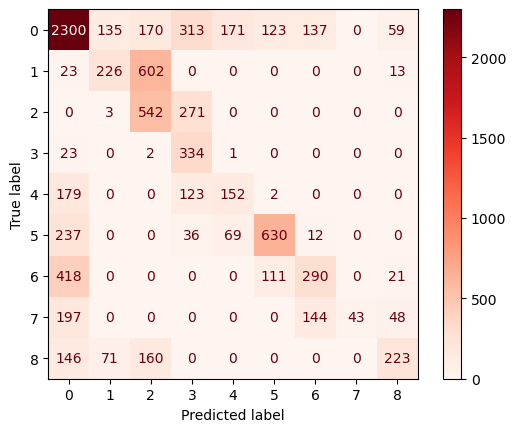

In [9]:
confusion_matrix = metrics.confusion_matrix(np.array(l_tot), np.array(p_tot))

cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix = confusion_matrix)

cm_display.plot(cmap='Reds')
plt.show()

In [10]:
def transform_doy(doy):
    """
    Transforms Day of Year (DOY) to a cyclical feature using a sine wave.

    Parameters:
    - doy (np.array): An array of DOY values ranging from 0 to 365.

    Returns:
    - np.array: Transformed DOY values oscillating between -1 and 1.
    """
    max_doy = 365.0  # Use 366 for leap years if necessary
    transformed_doy = np.sin(2 * np.pi * doy / max_doy)
    return transformed_doy
    
import torch
import torch.nn as nn
import torch.nn.functional as F

class CategoricalCNN(nn.Module):
    def __init__(self, input_shape, num_classes=9):
        super(CategoricalCNN, self).__init__()
        
        self.conv1 = nn.Conv2d(in_channels=input_shape[0], out_channels=32, kernel_size=3, padding=1)
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)
        self.conv2 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, padding=1)
        
        
        # Calculate the size of the flattened features after conv and pooling layers
        self.flattened_size = 64 * (input_shape[1] // 4) * (input_shape[2] // 4)
        
        # Fully connected layer
        self.fc1 = nn.Linear(self.flattened_size + 1, 128)  # +1 for DOY scalar
        self.fc2 = nn.Linear(128, num_classes)
        
    def forward(self, x, doy):
        """
        Forward pass through the model.
        
        Parameters:
            x (torch.Tensor): Input tensor (the image data).
            doy (torch.Tensor): Scalar input tensor representing day of the year.
        
        Returns:
            torch.Tensor: The output of the network.
        """
        x = self.pool(F.relu((self.conv1(x))))
        x = self.pool(F.relu((self.conv2(x))))
        x = x.view(-1, self.flattened_size)  # Flatten the tensor for the fully connected layer
        
        # Concatenate the DOY input with the flattened tensor
        doy = doy.view(-1, 1)  # Reshape DOY to have the same batch dimension as x
        x = torch.cat((x, doy), dim=1)  # Concatenate along the feature dimension
        
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x


class CategoricalCNN_2(nn.Module):
    def __init__(self, input_shape, num_classes=9):
        super(CategoricalCNN_2, self).__init__()
        
        self.conv1 = nn.Conv2d(in_channels=input_shape[0], out_channels=32, kernel_size=3, padding=1)
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)
        self.conv2 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, padding=1)
        
        
        # Calculate the size of the flattened features after conv and pooling layers
        self.flattened_size = 64 * (input_shape[1] // 4) * (input_shape[2] // 4)
        
        # Fully connected layer
        self.fc1 = nn.Linear(self.flattened_size + 1, 128)  # +1 for DOY scalar
        self.fc2 = nn.Linear(128, 128)  # +1 for DOY scalar
        self.fc3 = nn.Linear(128, num_classes)
        
    def forward(self, x, doy):
        """
        Forward pass through the model.
        
        Parameters:
            x (torch.Tensor): Input tensor (the image data).
            doy (torch.Tensor): Scalar input tensor representing day of the year.
        
        Returns:
            torch.Tensor: The output of the network.
        """
        x = self.pool(F.relu((self.conv1(x))))
        x = self.pool(F.relu((self.conv2(x))))
        x = x.view(-1, self.flattened_size)  # Flatten the tensor for the fully connected layer
        
        # Concatenate the DOY input with the flattened tensor
        doy = doy.view(-1, 1)  # Reshape DOY to have the same batch dimension as x
        x = torch.cat((x, doy), dim=1)  # Concatenate along the feature dimension
        
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

In [11]:
class SpatialDataset(Dataset):
    def __init__(self, X, y, doy):
        """
        Initialize the dataset.
        
        Parameters:
        - X: Features tensor or array
        - y: Target tensor or array
        - doy: Day of Year (DOY) tensor or array
        """
        # Ensure that X, y, and doy are torch tensors. If they are numpy arrays, convert them to torch tensors.
        self.X = torch.tensor(X, dtype=torch.float32) if not torch.is_tensor(X) else X
        self.y = torch.tensor(y, dtype=torch.long) if not torch.is_tensor(y) else y
        self.doy = torch.tensor(doy, dtype=torch.float32) if not torch.is_tensor(doy) else doy
    
    def __len__(self):
        # Return the length of the dataset
        return len(self.X)
    
    def __getitem__(self, idx):
        """
        Retrieve a sample and its label at a given index.
        
        Parameters:
        - idx: Index of the sample to retrieve
        
        Returns:
        - A tuple (feature, doy, label) for the specified index
        """
        return self.X[idx], self.doy[idx], self.y[idx]

## Train Test Val add DOY


In [31]:
DS = xr.open_dataset('./Classify_dataset_MJO.nc')
DS['U200']=DS['U'].sel(lev=200,method='nearest')
DS['V200']=DS['V'].sel(lev=200,method='nearest')
DS['U850']=DS['U'].sel(lev=850,method='nearest')
DS['V850']=DS['V'].sel(lev=850,method='nearest')
DS = DS.drop('U')
DS = DS.drop('V')
DStrain = DS.sel(time=slice('2000','2005'))
DSval = DS.sel(time=slice('2006','2006'))
DStest = DS.sel(time=slice('2007','2007'))
DStrainm = DStrain[['U200','U850','V200','V850','FLUTC']].mean(['time','lat','lon'])
DStrains = DStrain[['U200','U850','V200','V850','FLUTC']].std(['time','lat','lon'])

DStrain_norm = (DStrain - DStrainm)/DStrains
DStrain_doy = 2*transform_doy(np.array(DStrain['DOY']))
DSval_norm = (DSval - DStrainm)/DStrains
DSval_doy = 2*transform_doy(np.array(DSval['DOY']))
DStest_norm = (DStest - DStrainm)/DStrains
DStest_doy = 2*transform_doy(np.array(DStest['DOY']))

DStrain_norm_arr = np.array(DStrain_norm.to_array())
DStrain_norm_arr = np.swapaxes(DStrain_norm_arr,0,1)
DSval_norm_arr = np.array(DSval_norm.to_array())
DSval_norm_arr = np.swapaxes(DSval_norm_arr,0,1)
DStest_norm_arr = np.array(DStest_norm.to_array())
DStest_norm_arr = np.swapaxes(DStest_norm_arr,0,1)
DStrain_Y = np.array(DStrain['phase'])
DSval_Y = np.array(DSval['phase'])
DStest_Y = np.array(DStest['phase'])

## Array Order:
1.FLUTC 2.U200 3.V200 4.U850 5.V850 6.DOY

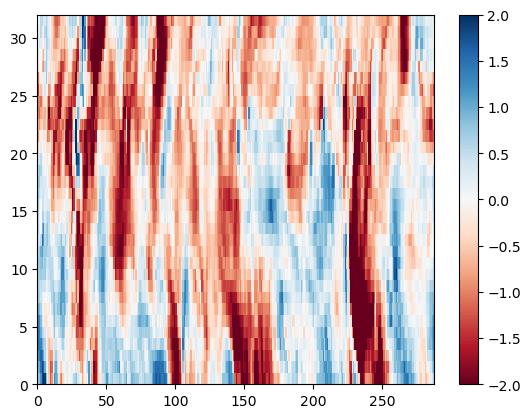

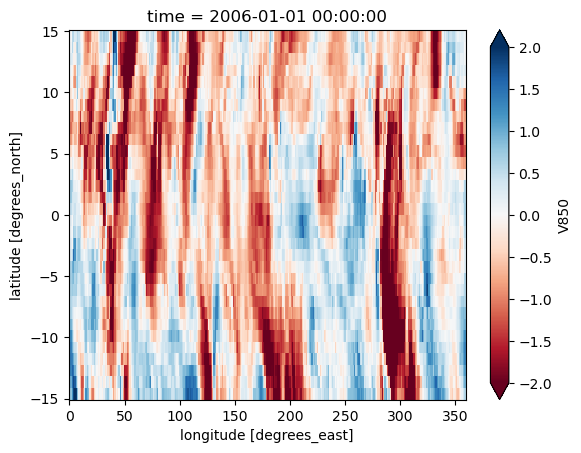

In [47]:
plt.pcolormesh(DSval_norm_arr[0,4,:,:],cmap='RdBu',vmin=-2,vmax=2)
plt.colorbar()
plt.show()

DSval_norm['V850'].isel(time=0).plot(cmap='RdBu',vmin=-2,vmax=2)
plt.show()

In [52]:
# Assuming X is your features array with shape (52441, 5, 32, 288)
# And y is your targets array with shape (52441,)
class_0_indices = np.where(DStrain_Y == 0)[0]
non_class_0_indices = np.where(DStrain_Y != 0)[0]

# Decide on the number of samples to keep for class '0'
# For example, let's say you want to match the number of samples of the next smallest class
# Here's a simple way to find that number, assuming the next smallest class has at least 5000 samples
desired_samples = 4000

# Randomly select desired_samples from class_0_indices
np.random.seed(42)  # For reproducibility
class_0_downsampled_indices = np.random.choice(class_0_indices, desired_samples, replace=False)

# Combine downsampled class '0' indices with non-class '0' indices
balanced_indices = np.concatenate((class_0_downsampled_indices, non_class_0_indices))

# Create the balanced dataset
DStrain_norm_arr_balanced = DStrain_norm_arr[balanced_indices]
DStrain_Y_balanced = DStrain_Y[balanced_indices]
DStrain_doy_balanced = DStrain_doy[balanced_indices]
##
weights=[]
for ii in range(9):
    class_0_indices = np.where(DStrain_Y_balanced == ii)[0]
    weights.append(len(class_0_indices))
weights=torch.tensor(weights)
weights = weights/sum(weights)
weights = 1/weights
weights[-1] = weights[-1]+6
weights[-2] = weights[-2]+8
weights[-3] = weights[-3]+10

In [14]:
# Check if CUDA (GPU support) is available and use it; otherwise, fall back to CPU
# device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
# print(f"Using device: {device}")

rem = DStrain_norm_arr_balanced.shape
input_shape = (rem[1],rem[2],rem[3]) # Example input shape (C, H, W)
model = CategoricalCNN_2(input_shape=input_shape, num_classes=9)
model = model.to(device)
criterion = nn.CrossEntropyLoss(weight=weights).to(device)
optimizer = optim.Adam(model.parameters(), lr=0.001)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='max', factor=0.5, patience=2, verbose=True)
train_dataset = SpatialDataset(DStrain_norm_arr_balanced,DStrain_Y_balanced,DStrain_doy)
val_dataset = SpatialDataset(DSval_norm_arr,DSval_Y,DSval_doy)

train_loader = DataLoader(train_dataset, batch_size=128, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=128, shuffle=False)
num_epochs=40

for epoch in range(num_epochs):
    model.train()  # Set the model to training mode
    print(f"Starting Epoch {epoch}")
    nsampsseen = 0
    running_loss = 0.0
    for inputs, doys, labels in train_loader:
        inputs = inputs.to(device)
        doys = doys.to(device)
        labels = labels.to(device)
        optimizer.zero_grad()
        outputs = model(inputs, doys).to(device)
        loss = criterion(outputs.to(device), labels.to(device))
        loss.backward()
        optimizer.step()
        running_loss += loss.item() * inputs.size(0)
        nsampsseen += inputs.shape[0]
        if nsampsseen > 4500:
            break
    epoch_loss = running_loss / nsampsseen
    print(f"Epoch {epoch}, Loss: {epoch_loss:.4f}")

    # Validation loop
    model.eval()  # Set the model to evaluation mode
    correct = 0
    total = 0
    with torch.no_grad():  # In validation phase, we don't need to compute gradients
        for inputs, doys, labels in val_loader:
            labels = labels.to(device)
            outputs = model(inputs.to(device), doys.to(device))
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels.to(device)).sum().item()
    
    # Calculate and print validation accuracy
    val_accuracy = 100 * correct / total
    print(f"Validation Accuracy: {val_accuracy:.2f}%")
    if epoch == 0:
        print('...saved first epoch...')
        best_mod = copy.deepcopy(model)
        best_acc = copy.deepcopy(val_accuracy)
    elif val_accuracy>best_acc:
        print('...saving!...')
        best_mod = copy.deepcopy(model)
        best_acc = copy.deepcopy(val_accuracy)
    else:
        print('No improvement in validation accuracy.')
    # Step the scheduler on each epoch
    scheduler.step(val_accuracy)

Starting Epoch 0
Epoch 0, Loss: 1.3646
Validation Accuracy: 51.89%
...saved first epoch...
Starting Epoch 1
Epoch 1, Loss: 0.5040
Validation Accuracy: 52.18%
...saving!...
Starting Epoch 2
Epoch 2, Loss: 0.3109
Validation Accuracy: 59.53%
...saving!...
Starting Epoch 3
Epoch 3, Loss: 0.2367
Validation Accuracy: 59.93%
...saving!...
Starting Epoch 4
Epoch 4, Loss: 0.1874
Validation Accuracy: 63.94%
...saving!...
Starting Epoch 5
Epoch 5, Loss: 0.1874
Validation Accuracy: 62.13%
No improvement in validation accuracy.
Starting Epoch 6
Epoch 6, Loss: 0.1213
Validation Accuracy: 61.94%
No improvement in validation accuracy.
Starting Epoch 7
Epoch 7, Loss: 0.0992
Validation Accuracy: 59.10%
No improvement in validation accuracy.
Epoch 00008: reducing learning rate of group 0 to 5.0000e-04.
Starting Epoch 8
Epoch 8, Loss: 0.0779
Validation Accuracy: 62.96%
No improvement in validation accuracy.
Starting Epoch 9
Epoch 9, Loss: 0.0574
Validation Accuracy: 59.89%
No improvement in validation acc

## Look at Stats

In [15]:
# Validation loop
#to get probabilities: probabilities = F.softmax(outputs, dim=1)
test_dataset = SpatialDataset(DStest_norm_arr, DStest_Y, DStest_doy)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

best_mod.eval()  # Set the model to evaluation mode
correct = 0
total = 0
l_tot = []
p_tot = []
prob_tot = []
countup = 0
probs_tot = torch.tensor([]) 

with torch.no_grad():  # In validation phase, we don't need to compute gradients
    for inputs, doys, labels in test_loader:
        outputs = best_mod(inputs.to(device), doys.to(device))
        _, predicted = torch.max(outputs.data, 1)
        probabilities = F.softmax(outputs, dim=1)
        predicted_prob, _ = torch.max(probabilities, 1)
        for ee,bb in enumerate(probabilities):
            if torch.max(bb)>0.3:
                predicted[ee]=predicted[ee]
            else:
                countup+=1
                predicted[ee]=0
        labels = labels.to(device)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

        l_tot+=list(np.array(labels.cpu()))
        p_tot+=list(np.array(predicted.cpu()))
        prob_tot+=list(np.array(predicted_prob.cpu()))
        probs_tot=torch.concat([probs_tot.cpu(),probabilities.cpu()],dim=0)
# Calculate and print validation accuracy
test_accuracy = 100 * correct / total
print(f"Testing Accuracy: {test_accuracy:.2f}%")
print(f"didnt classify: {countup} times'") 

Testing Accuracy: 60.10%
didnt classify: 5 times'


In [16]:
corr=0
missd=0
ind_miss_0 = []
ind_miss_4 = []
ind_pred_0_bad = []
ind_pred_6_bad = []


for bb in range(len(l_tot)):
    if l_tot[bb] == p_tot[bb]:
        corr+=1
        continue

    if p_tot[bb] == 4:
        ind_miss_4.append(bb)
    if l_tot[bb] == 6:
        ind_pred_6_bad.append(bb)

    if p_tot[bb]==0:
        ind_pred_0_bad.append(bb)
    if l_tot[bb]==0:
        ind_miss_0.append(bb)
        missd+=1
        continue

    
    if p_tot[bb] == 8:
        if l_tot[bb] == 7:
            corr += 1
            continue
        if l_tot[bb ]== 1:
            corr += 1
            continue

    if np.abs(p_tot[bb]-l_tot[bb]) == 1:
        corr += 1
        continue
    if np.abs(p_tot[bb]-l_tot[bb]) == 2:
        corr += 1
        continue
    else:
        missd += 1
print(f"Testing Fuzzy Accuracy: {100*(corr/(missd+corr)):.2f}%")

Testing Fuzzy Accuracy: 76.63%


## Confusion Matrix

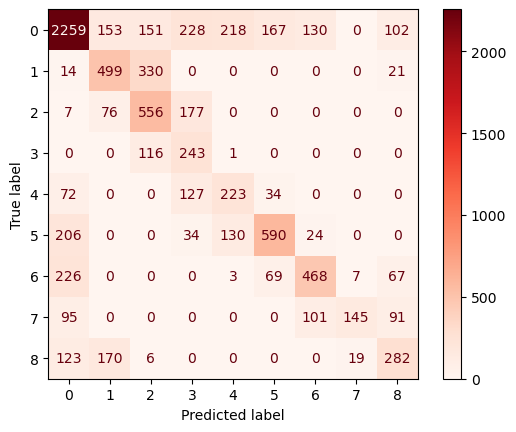

In [17]:
confusion_matrix = metrics.confusion_matrix(np.array(l_tot), np.array(p_tot))
cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix = confusion_matrix)
cm_display.plot(cmap='Reds')
plt.show()

## What is the amplitude of the Pred when it guesses 4 but is actually 0

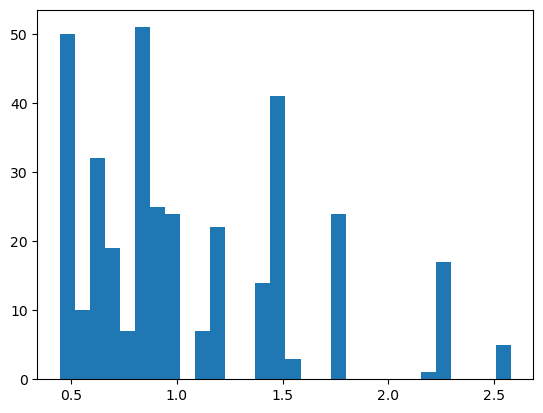

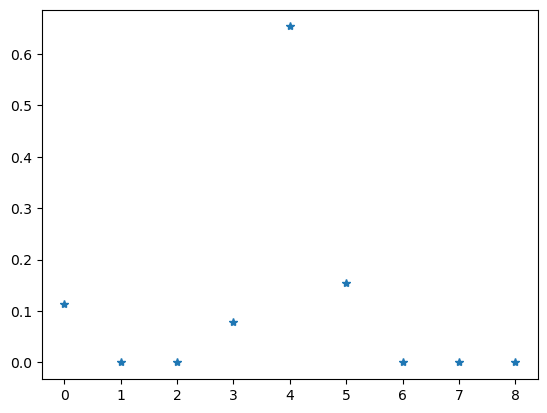

In [18]:
plt.hist(DStest['amplitude'].isel(time=ind_miss_4),30)
plt.show()
plt.plot(np.mean(probs_tot[ind_miss_4,:].detach().numpy(),axis=0),'*')
plt.show()

## Amplitdue of the times when it guesses not 0

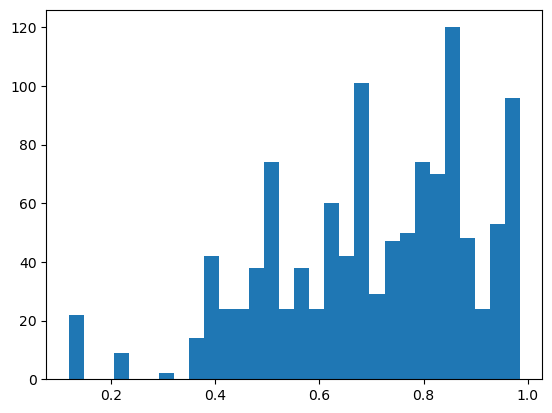

In [19]:
plt.hist(DStest['amplitude'].isel(time=ind_miss_0),30)
plt.show()

## When it's predicting 0 instead of six, what are the probs:

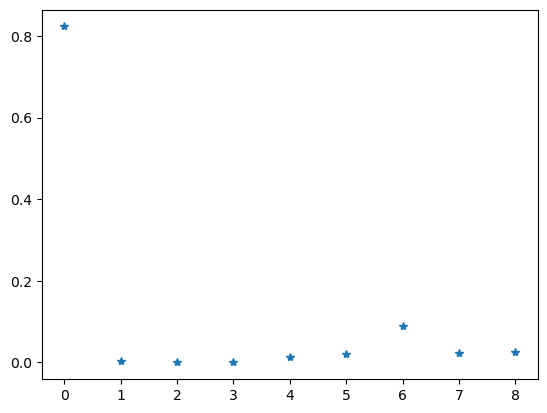

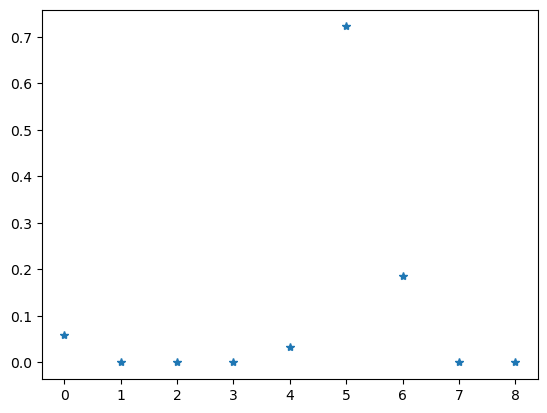

In [20]:
ind_pred_6_bad_ss =np.array(ind_pred_6_bad)[np.array(p_tot)[ind_pred_6_bad]==0]
plt.plot(np.mean(probs_tot[ind_pred_6_bad_ss,:].detach().numpy(),axis=0),'*')
plt.show()

ind_pred_6_bad_ss =np.array(ind_pred_6_bad)[np.array(p_tot)[ind_pred_6_bad]==5]
plt.plot(np.mean(probs_tot[ind_pred_6_bad_ss,:].detach().numpy(),axis=0),'*')
plt.show()

## Get all of the indices and scaling weights for the model 

In [21]:
## 
U200m = 0.83579528
U200s = 13.20837984
V200m = -0.40176933
V200s = 7.4425693
U850m = -3.5611767
U850s = 5.63111131
V850m = 0.3286065
V850s = 3.2882435
FLUTCm = 280.6467022
FLUTCs = 12.20693268

#lat is 32 long... Fortran is 1 indexed...
lev200 = 15
lev850 = 26
latlow = 81
lathi = 113

# DOY_formula=
def transform_doy(doy):
    """
    Transforms Day of Year (DOY) to a cyclical feature using a sine wave.

    Parameters:
    - doy (np.array): An array of DOY values ranging from 0 to 365.

    Returns:
    - np.array: Transformed DOY values oscillating between -1 and 1.
    """
    max_doy = 365.0  # Use 366 for leap years if necessary
    transformed_doy = np.sin(2 * np.pi * doy / max_doy)
    return transformed_doy

## Load from a saved file

In [41]:
momo_load = CategoricalCNN_2(input_shape=input_shape, num_classes=9)
momo_load.load_state_dict(torch.load('./Categorical_MJO_CNN_GPU_testingACC.60.6.pt'))
# Validation loop
device = 'cuda'

#to get probabilities: probabilities = F.softmax(outputs, dim=1)
test_dataset = SpatialDataset(DStest_norm_arr, DStest_Y, DStest_doy)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

momo_load.eval()  # Set the model to evaluation mode
correct = 0
total = 0
l_tot = []
p_tot = []
prob_tot = []
countup = 0
probs_tot = torch.tensor([]) 

momo_load.to(device)

with torch.no_grad():  # In validation phase, we don't need to compute gradients
    for inputs, doys, labels in test_loader:
        outputs = momo_load(inputs.to(device), doys.to(device))
        _, predicted = torch.max(outputs.data, 1)
        probabilities = F.softmax(outputs, dim=1)
        predicted_prob, _ = torch.max(probabilities, 1)
        for ee,bb in enumerate(probabilities):
            if torch.max(bb)>0.3:
                predicted[ee]=predicted[ee]
            else:
                countup+=1
                predicted[ee]=0
        labels = labels.to(device)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

        l_tot+=list(np.array(labels.cpu()))
        p_tot+=list(np.array(predicted.cpu()))
        prob_tot+=list(np.array(predicted_prob.cpu()))
        probs_tot=torch.concat([probs_tot.cpu(),probabilities.cpu()],dim=0)
# Calculate and print validation accuracy
test_accuracy = 100 * correct / total
print(f"Testing Accuracy: {test_accuracy:.2f}%")
print(f"didnt classify: {countup} times'") 

Testing Accuracy: 60.10%
didnt classify: 5 times'


In [43]:
momo_load = CategoricalCNN_2(input_shape=input_shape, num_classes=9)
momo_load.load_state_dict(torch.load('./Categorical_MJO_CNN_CPU_testingACC.60.6.pt'))
# Validation loop
device='cpu'
#to get probabilities: probabilities = F.softmax(outputs, dim=1)
test_dataset = SpatialDataset(DStest_norm_arr, DStest_Y, DStest_doy)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

momo_load.eval()  # Set the model to evaluation mode
correct = 0
total = 0
l_tot = []
p_tot = []
prob_tot = []
countup = 0
probs_tot = torch.tensor([]) 

momo_load.to(device)

with torch.no_grad():  # In validation phase, we don't need to compute gradients
    for inputs, doys, labels in test_loader:
        outputs = momo_load(inputs.to(device), doys.to(device))
        _, predicted = torch.max(outputs.data, 1)
        probabilities = F.softmax(outputs, dim=1)
        predicted_prob, _ = torch.max(probabilities, 1)
        for ee,bb in enumerate(probabilities):
            if torch.max(bb)>0.3:
                predicted[ee]=predicted[ee]
            else:
                countup+=1
                predicted[ee]=0
        labels = labels.to(device)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

        l_tot+=list(np.array(labels.cpu()))
        p_tot+=list(np.array(predicted.cpu()))
        prob_tot+=list(np.array(predicted_prob.cpu()))
        probs_tot=torch.concat([probs_tot.cpu(),probabilities.cpu()],dim=0)
# Calculate and print validation accuracy
test_accuracy = 100 * correct / total
print(f"Testing Accuracy: {test_accuracy:.2f}%")
print(f"didnt classify: {countup} times'") 

Testing Accuracy: 60.11%
didnt classify: 5 times'


## Skip to Here!

In [10]:
def transform_doy(doy):
    """
    Transforms Day of Year (DOY) to a cyclical feature using a sine wave.

    Parameters:
    - doy (np.array): An array of DOY values ranging from 0 to 365.

    Returns:
    - np.array: Transformed DOY values oscillating between -1 and 1.
    """
    max_doy = 365.0  # Use 366 for leap years if necessary
    transformed_doy = np.sin(2 * np.pi * doy / max_doy)
    return transformed_doy
    
DS = xr.open_dataset('/glade/work/wchapman/DA_ML/CESML_AI/MJO_Increments/Classify_dataset_MJO.nc')
DS['U200']=DS['U'].sel(lev=200,method='nearest')
DS['V200']=DS['V'].sel(lev=200,method='nearest')
DS['U850']=DS['U'].sel(lev=850,method='nearest')
DS['V850']=DS['V'].sel(lev=850,method='nearest')
DS = DS.drop('U')
DS = DS.drop('V')
DStrain = DS.sel(time=slice('2000','2005'))
DSval = DS.sel(time=slice('2006','2006'))
DStest = DS.sel(time=slice('2007','2007'))
DStrainm = DStrain[['U200','U850','V200','V850','FLUTC']].mean(['time','lat','lon'])
DStrains = DStrain[['U200','U850','V200','V850','FLUTC']].std(['time','lat','lon'])

DStrain_norm = (DStrain - DStrainm)/DStrains
DStrain_doy = 2*transform_doy(np.array(DStrain['DOY']))
DSval_norm = (DSval - DStrainm)/DStrains
DSval_doy = 2*transform_doy(np.array(DSval['DOY']))
DStest_norm = (DStest - DStrainm)/DStrains
DStest_doy = 2*transform_doy(np.array(DStest['DOY']))

DStrain_norm_arr = np.array(DStrain_norm.to_array())
DStrain_norm_arr = np.swapaxes(DStrain_norm_arr,0,1)
DSval_norm_arr = np.array(DSval_norm.to_array())
DSval_norm_arr = np.swapaxes(DSval_norm_arr,0,1)
DStest_norm_arr = np.array(DStest_norm.to_array())
DStest_norm_arr = np.swapaxes(DStest_norm_arr,0,1)
DStrain_Y = np.array(DStrain['phase'])
DSval_Y = np.array(DSval['phase'])
DStest_Y = np.array(DStest['phase'])

In [11]:
class SpatialDataset(Dataset):
    def __init__(self, X, y, doy):
        """
        Initialize the dataset.
        
        Parameters:
        - X: Features tensor or array
        - y: Target tensor or array
        - doy: Day of Year (DOY) tensor or array
        """
        # Ensure that X, y, and doy are torch tensors. If they are numpy arrays, convert them to torch tensors.
        self.X = torch.tensor(X, dtype=torch.float32) if not torch.is_tensor(X) else X
        self.y = torch.tensor(y, dtype=torch.long) if not torch.is_tensor(y) else y
        self.doy = torch.tensor(doy, dtype=torch.float32) if not torch.is_tensor(doy) else doy
    
    def __len__(self):
        # Return the length of the dataset
        return len(self.X)
    
    def __getitem__(self, idx):
        """
        Retrieve a sample and its label at a given index.
        
        Parameters:
        - idx: Index of the sample to retrieve
        
        Returns:
        - A tuple (feature, doy, label) for the specified index
        """
        return self.X[idx], self.doy[idx], self.y[idx]

class MJOcnnClassify(nn.Module):
    def __init__(self):
        super().__init__()
        input_shape = [5, 32, 288]
        num_classes = 9
        weights_path = '/glade/work/wchapman/DA_ML/CESML_AI/MJO_Increments/Categorical_MJO_CNN_CPU_testingACC.60.6.pt'
        device = 'cpu'
        # Model architecture
        self.conv1 = nn.Conv2d(in_channels=input_shape[0], out_channels=32, kernel_size=3, padding=1)
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)
        self.conv2 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, padding=1)
        self.flattened_size = 64 * (input_shape[1] // 4) * (input_shape[2] // 4)
        self.fc1 = nn.Linear(self.flattened_size + 1, 128)  # +1 for DOY scalar
        self.fc2 = nn.Linear(128, 128)
        self.fc3 = nn.Linear(128, num_classes)
        
        self.device = torch.device(device)
        self.to(self.device)  # Move model to the specified device
        
        # Load model weights after architecture is defined
        self.load_model_weights(weights_path)
        
    def load_model_weights(self, weights_path):
        # Load the state dict with appropriate device mapping
        state_dict = torch.load(weights_path, map_location=self.device)
        self.load_state_dict(state_dict)

    def forward(self, x, doy):
        """
        Forward pass through the model.
        
        Parameters:
            x (torch.Tensor): Input tensor (the image data).
            doy (torch.Tensor): Scalar input tensor representing day of the year.
        
        Returns:
            torch.Tensor: The output of the network.
        """
        x = self.pool(F.relu((self.conv1(x))))
        x = self.pool(F.relu((self.conv2(x))))
        x = x.view(-1, self.flattened_size)  # Flatten the tensor for the fully connected layer
        
        # Concatenate the DOY input with the flattened tensor
        doy = doy.view(-1, 1)  # Reshape DOY to have the same batch dimension as x
        x = torch.cat((x, doy), dim=1)  # Concatenate along the feature dimension
        
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

In [12]:
momo_load = MJOcnnClassify()
# momo_load.load_state_dict(torch.load('./Categorical_MJO_CNN_GPU_testingACC.60.6.pt'))
# Validation loop
device = 'cpu'

#to get probabilities: probabilities = F.softmax(outputs, dim=1)
test_dataset = SpatialDataset(DStest_norm_arr, DStest_Y, DStest_doy)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

momo_load.eval()  # Set the model to evaluation mode
correct = 0
total = 0
l_tot = []
p_tot = []
prob_tot = []
countup = 0
probs_tot = torch.tensor([]) 

momo_load.to(device)

with torch.no_grad():  # In validation phase, we don't need to compute gradients
    for inputs, doys, labels in test_loader:
        outputs = momo_load(inputs.to(device), doys.to(device))
        _, predicted = torch.max(outputs.data, 1)
        probabilities = F.softmax(outputs, dim=1)
        predicted_prob, _ = torch.max(probabilities, 1)
        for ee,bb in enumerate(probabilities):
            if torch.max(bb)>0.3:
                predicted[ee]=predicted[ee]
            else:
                countup+=1
                predicted[ee]=0
        labels = labels.to(device)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

        l_tot+=list(np.array(labels.cpu()))
        p_tot+=list(np.array(predicted.cpu()))
        prob_tot+=list(np.array(predicted_prob.cpu()))
        probs_tot=torch.concat([probs_tot.cpu(),probabilities.cpu()],dim=0)
# Calculate and print validation accuracy
test_accuracy = 100 * correct / total
print(f"Testing Accuracy: {test_accuracy:.2f}%")
print(f"didnt classify: {countup} times'") 

Testing Accuracy: 60.11%
didnt classify: 5 times'


## Confusion Matrix and Fuzzy  Accuracy

In [13]:
corr=0
missd=0
ind_miss_0 = []
ind_miss_4 = []
ind_pred_0_bad = []
ind_pred_6_bad = []


for bb in range(len(l_tot)):
    if l_tot[bb] == p_tot[bb]:
        corr+=1
        continue

    if p_tot[bb] == 4:
        ind_miss_4.append(bb)
    if l_tot[bb] == 6:
        ind_pred_6_bad.append(bb)

    if p_tot[bb]==0:
        ind_pred_0_bad.append(bb)
    if l_tot[bb]==0:
        ind_miss_0.append(bb)
        missd+=1
        continue

    
    if p_tot[bb] == 8:
        if l_tot[bb] == 7:
            corr += 1
            continue
        if l_tot[bb ]== 1:
            corr += 1
            continue

    if np.abs(p_tot[bb]-l_tot[bb]) == 1:
        corr += 1
        continue
    if np.abs(p_tot[bb]-l_tot[bb]) == 2:
        corr += 1
        continue
    else:
        missd += 1
FZacc = 100*(corr/(missd+corr))
print(f"Testing Fuzzy Accuracy: {FZacc:.2f}%")

Testing Fuzzy Accuracy: 76.64%


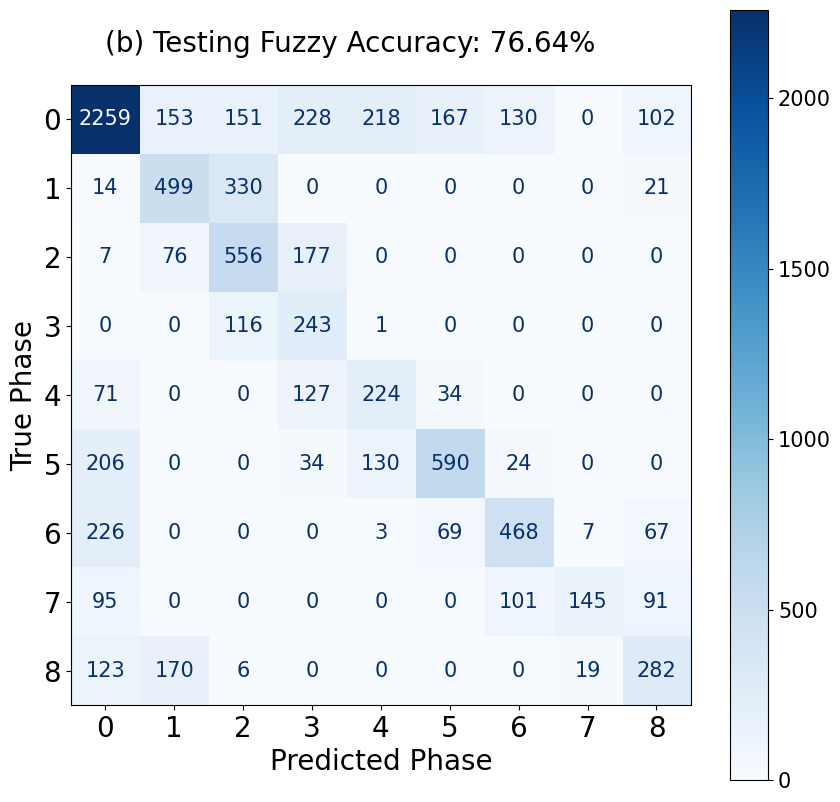

In [71]:
bbox_props = dict(fc="white", ec="white", lw=2)
fig, ax = plt.subplots(figsize=(10,10))

confusion_matrix = metrics.confusion_matrix(np.array(l_tot), np.array(p_tot))
cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix = confusion_matrix)
cm_display.plot(cmap='Blues',ax=ax)
plt.rcParams.update({'font.size': 15})

plt.xlabel('Predicted Phase',fontsize=20)
plt.ylabel('True Phase',fontsize=20)
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
plt.text(0, -1.3, f'(b) Testing Fuzzy Accuracy: {FZacc:.2f}%', ha='left', va='top', fontsize=20, bbox=bbox_props)
plt.savefig('./ConfusionMatrixMJO.png',bbox_inches='tight',dpi=400)
plt.show()

## Add DOY as an additional input 

In [3]:
class CategoricalCNN(nn.Module):
    def __init__(self, input_shape, num_classes=9):
        """
        Initialize the CNN model.
        
        Parameters:
            input_shape (tuple): The shape of the input images (C, H, W).
            num_classes (int): The number of classes for prediction.
        """
        super(CategoricalCNN, self).__init__()
        
        self.conv1 = nn.Conv2d(in_channels=input_shape[0], out_channels=32, kernel_size=3, padding=1)
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)
        self.conv2 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, padding=1)
        
        # Calculate the size of the flattened features after conv and pooling layers
        self.flattened_size = 64 * (input_shape[1] // 4) * (input_shape[2] // 4)
        
        self.fc1 = nn.Linear(self.flattened_size, 128)
        self.fc2 = nn.Linear(128, num_classes)
        
    def forward(self, x):
        """
        Forward pass through the model.
        
        Parameters:
            x (torch.Tensor): Input tensor.
        
        Returns:
            torch.Tensor: The output of the network.
        """
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = x.view(-1, self.flattened_size)  # Flatten the tensor for the fully connected layer
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x


class SpatialDataset(Dataset):
    def __init__(self, X, y):
        self.X = torch.tensor(X, dtype=torch.float32)
        self.y = torch.tensor(y, dtype=torch.long)
    
    def __len__(self):
        return len(self.X)
    
    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]

## Load Data

In [4]:
# DOY_formula=
def transform_doy(doy):
    """
    Transforms Day of Year (DOY) to a cyclical feature using a sine wave.

    Parameters:
    - doy (np.array): An array of DOY values ranging from 0 to 365.

    Returns:
    - np.array: Transformed DOY values oscillating between -1 and 1.
    """
    max_doy = 365.0  # Use 366 for leap years if necessary
    transformed_doy = np.sin(2 * np.pi * doy / max_doy)
    return transformed_doy

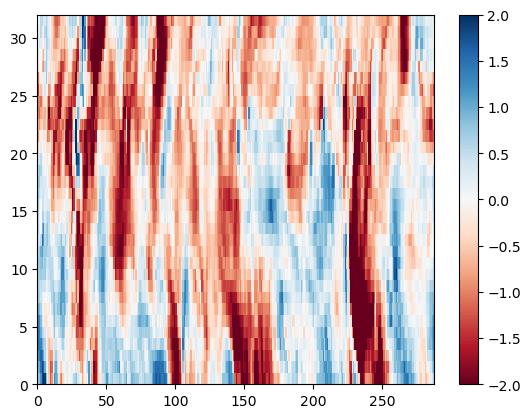

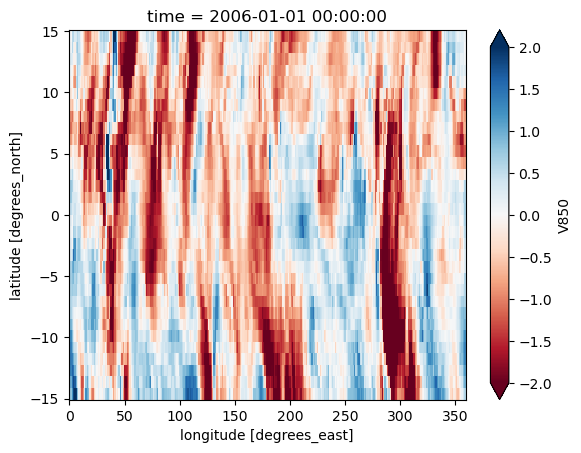

In [30]:
plt.pcolormesh(np.swapaxes(np.array(DSval_norm.to_array()), 0, 1)[0,3,:,:],cmap='RdBu',vmin=-2,vmax=2)
plt.colorbar()
plt.show()

DSval_norm['V850'].isel(time=0).plot(cmap='RdBu',vmin=-2,vmax=2)
plt.show()

## Array Order:
1.FLUTC 2.U200 3.V200 4.U850 5.V850 6.DOY

In [54]:
DS = xr.open_dataset('./Classify_dataset_MJO.nc')
DS['U200']=DS['U'].sel(lev=200,method='nearest')
DS['V200']=DS['V'].sel(lev=200,method='nearest')
DS['U850']=DS['U'].sel(lev=850,method='nearest')
DS['V850']=DS['V'].sel(lev=850,method='nearest')
DS = DS.drop('U')
DS = DS.drop('V')
DStrain = DS.sel(time=slice('2000','2005'))
DSval = DS.sel(time=slice('2006','2006'))
DStest = DS.sel(time=slice('2007','2007'))
DStrainm = DStrain[['FLUTC','U200','U850','V200','V850']].mean(['time','lat','lon'])
DStrains = DStrain[['FLUTC','U200','U850','V200','V850']].std(['time','lat','lon'])

DStrain_norm = (DStrain - DStrainm)/DStrains
DStrain_doy = 2*transform_doy(np.array(DStrain['DOY']))
DSval_norm = (DSval - DStrainm)/DStrains
DSval_doy = 2*transform_doy(np.array(DSval['DOY']))
DStest_norm = (DStest - DStrainm)/DStrains
DStest_doy = 2*transform_doy(np.array(DStest['DOY']))

DStrain_norm_arr = np.array(DStrain_norm.to_array())
DStrain_norm_arr = np.swapaxes(DStrain_norm_arr, 0, 1)
# Reshape and repeat the example array to match the desired shape
doy_reshaped = np.repeat(DStrain_doy.reshape(DStrain_doy.shape[0], 1, 1, 1), 1, axis=1)
doy_reshaped = np.repeat(doy_reshaped, 32, axis=2)
doy_reshaped = np.repeat(doy_reshaped, 288, axis=3)
DStrain_norm_arr = np.concatenate([DStrain_norm_arr, doy_reshaped], axis=1)

DSval_norm_arr = np.array(DSval_norm.to_array())
DSval_norm_arr = np.swapaxes(DSval_norm_arr, 0, 1)
# Reshape and repeat the example array to match the desired shape
doy_reshaped = np.repeat(DSval_doy.reshape(DSval_doy.shape[0], 1, 1, 1), 1, axis=1)
doy_reshaped = np.repeat(doy_reshaped, 32, axis=2)
doy_reshaped = np.repeat(doy_reshaped, 288, axis=3)
DSval_norm_arr = np.concatenate([DSval_norm_arr, doy_reshaped], axis=1)

DStest_norm_arr = np.array(DStest_norm.to_array())
DStest_norm_arr = np.swapaxes(DStest_norm_arr, 0, 1)
# Reshape and repeat the example array to match the desired shape
doy_reshaped = np.repeat(DStest_doy.reshape(DStest_doy.shape[0], 1, 1, 1), 1, axis=1)
doy_reshaped = np.repeat(doy_reshaped, 32, axis=2)
doy_reshaped = np.repeat(doy_reshaped, 288, axis=3)
DStest_norm_arr = np.concatenate([DStest_norm_arr, doy_reshaped], axis=1)


DStrain_Y = np.array(DStrain['phase'])
DSval_Y = np.array(DSval['phase'])
DStest_Y = np.array(DStest['phase'])

In [6]:
# Assuming X is your features array with shape (52441, 6, 32, 288)
# And y is your targets array with shape (52441,)
class_0_indices = np.where(DStrain_Y == 0)[0]
non_class_0_indices = np.where(DStrain_Y != 0)[0]

# Decide on the number of samples to keep for class '0'
# For example, let's say you want to match the number of samples of the next smallest class
# Here's a simple way to find that number, assuming the next smallest class has at least 5000 samples
desired_samples = 4000

# Randomly select desired_samples from class_0_indices
np.random.seed(42)  # For reproducibility
class_0_downsampled_indices = np.random.choice(class_0_indices, desired_samples, replace=False)

# Combine downsampled class '0' indices with non-class '0' indices
balanced_indices = np.concatenate((class_0_downsampled_indices, non_class_0_indices))

# Create the balanced dataset
DStrain_norm_arr_balanced = DStrain_norm_arr[balanced_indices]
DStrain_Y_balanced = DStrain_Y[balanced_indices]
DStrain_doy_balanced = DStrain_doy[balanced_indices]
##
weights=[]
for ii in range(9):
    class_0_indices = np.where(DStrain_Y_balanced == ii)[0]
    weights.append(len(class_0_indices))
weights=torch.tensor(weights)
weights = weights/sum(weights)
weights = 1/weights
weights[-1] = weights[-1]+6
weights[-2] = weights[-2]+8
weights[-3] = weights[-3]+10

In [7]:
# Check if CUDA (GPU support) is available and use it; otherwise, fall back to CPU
# device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
# print(f"Using device: {device}")

rem = DStrain_norm_arr_balanced.shape
input_shape = (rem[1],rem[2],rem[3]) # Example input shape (C, H, W)
model = CategoricalCNN(input_shape=input_shape, num_classes=9)
model = model.to(device)
criterion = nn.CrossEntropyLoss(weight=weights).to(device)
optimizer = optim.Adam(model.parameters(), lr=0.001)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='max', factor=0.5, patience=2, verbose=True)
train_dataset = SpatialDataset(DStrain_norm_arr_balanced,DStrain_Y_balanced)
val_dataset = SpatialDataset(DSval_norm_arr,DSval_Y)

train_loader = DataLoader(train_dataset, batch_size=128, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=128, shuffle=False)
num_epochs=40

for epoch in range(num_epochs):
    model.train()  # Set the model to training mode
    print(f"Starting Epoch {epoch}")
    nsampsseen = 0
    running_loss = 0.0
    for inputs, labels in train_loader:
        inputs = inputs.to(device)
        labels = labels.to(device)
        optimizer.zero_grad()
        outputs = model(inputs).to(device)
        loss = criterion(outputs.to(device), labels.to(device))
        loss.backward()
        optimizer.step()
        running_loss += loss.item() * inputs.size(0)
        nsampsseen += inputs.shape[0]
        if nsampsseen > 4500:
            break
    epoch_loss = running_loss / nsampsseen
    print(f"Epoch {epoch}, Loss: {epoch_loss:.4f}")

    # Validation loop
    model.eval()  # Set the model to evaluation mode
    correct = 0
    total = 0
    with torch.no_grad():  # In validation phase, we don't need to compute gradients
        for inputs, labels in val_loader:
            labels = labels.to(device)
            outputs = model(inputs.to(device),)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels.to(device)).sum().item()
    
    # Calculate and print validation accuracy
    val_accuracy = 100 * correct / total
    print(f"Validation Accuracy: {val_accuracy:.2f}%")
    if epoch == 0:
        print('...saved first epoch...')
        best_mod = copy.deepcopy(model)
        best_acc = copy.deepcopy(val_accuracy)
    elif val_accuracy>best_acc:
        print('...saving!...')
        best_mod = copy.deepcopy(model)
        best_acc = copy.deepcopy(val_accuracy)
    else:
        print('No improvement in validation accuracy.')
    # Step the scheduler on each epoch
    scheduler.step(val_accuracy)

Starting Epoch 0
Epoch 0, Loss: 2.4103
Validation Accuracy: 7.07%
...saved first epoch...
Starting Epoch 1
Epoch 1, Loss: 1.6832
Validation Accuracy: 36.26%
...saving!...
Starting Epoch 2
Epoch 2, Loss: 0.7554
Validation Accuracy: 46.88%
...saving!...
Starting Epoch 3
Epoch 3, Loss: 0.4593
Validation Accuracy: 55.24%
...saving!...
Starting Epoch 4
Epoch 4, Loss: 0.3215
Validation Accuracy: 59.94%
...saving!...
Starting Epoch 5
Epoch 5, Loss: 0.2256
Validation Accuracy: 57.21%
No improvement in validation accuracy.
Starting Epoch 6
Epoch 6, Loss: 0.1701
Validation Accuracy: 56.03%
No improvement in validation accuracy.
Starting Epoch 7
Epoch 7, Loss: 0.1547
Validation Accuracy: 58.96%
No improvement in validation accuracy.
Epoch 00008: reducing learning rate of group 0 to 5.0000e-04.
Starting Epoch 8
Epoch 8, Loss: 0.1132
Validation Accuracy: 60.57%
...saving!...
Starting Epoch 9
Epoch 9, Loss: 0.0924
Validation Accuracy: 61.62%
...saving!...
Starting Epoch 10
Epoch 10, Loss: 0.0725
Val

In [160]:
# Validation loop
#to get probabilities: probabilities = F.softmax(outputs, dim=1)
test_dataset = SpatialDataset(DStest_norm_arr, DStest_Y)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

best_mod.eval()  # Set the model to evaluation mode
correct = 0
total = 0
l_tot = []
p_tot = []
prob_tot = []
countup = 0
probs_tot = torch.tensor([]) 

with torch.no_grad():  # In validation phase, we don't need to compute gradients
    for inputs, labels in test_loader:
        outputs = best_mod(inputs.to(device))
        _, predicted = torch.max(outputs.data, 1)
        probabilities = F.softmax(outputs, dim=1)
        predicted_prob, _ = torch.max(probabilities, 1)
        for ee,bb in enumerate(probabilities):
            if torch.max(bb)>0.3:
                predicted[ee]=predicted[ee]
            else:
                countup+=1
                predicted[ee]=0
        labels = labels.to(device)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

        l_tot+=list(np.array(labels.cpu()))
        p_tot+=list(np.array(predicted.cpu()))
        prob_tot+=list(np.array(predicted_prob.cpu()))
        probs_tot=torch.concat([probs_tot.cpu(),probabilities.cpu()],dim=0)
# Calculate and print validation accuracy
test_accuracy = 100 * correct / total
print(f"Testing Accuracy: {test_accuracy:.2f}%")
print(f"didnt classify: {countup} times'") 

Testing Accuracy: 54.55%
didnt classify: 0 times'


In [163]:
corr=0
missd=0
ind_miss_0 = []
ind_miss_4 = []
ind_pred_0_bad = []
ind_pred_6_bad = []


for bb in range(len(l_tot)):
    if l_tot[bb] == p_tot[bb]:
        corr+=1
        continue

    if p_tot[bb] == 4:
        ind_miss_4.append(bb)
    if l_tot[bb] == 6:
        ind_pred_6_bad.append(bb)

    if p_tot[bb]==0:
        ind_pred_0_bad.append(bb)
    if l_tot[bb]==0:
        ind_miss_0.append(bb)
        missd+=1
        continue

    
    if p_tot[bb] == 8:
        if l_tot[bb] == 7:
            corr += 1
            continue
        if l_tot[bb ]== 1:
            corr += 1
            continue

    if np.abs(p_tot[bb]-l_tot[bb]) == 1:
        corr += 1
        continue
    if np.abs(p_tot[bb]-l_tot[bb]) == 2:
        corr += 1
        continue
    else:
        missd += 1
print(f"Testing Fuzzy Accuracy: {100*(corr/(missd+corr)):.2f}%")

Testing Fuzzy Accuracy: 74.44%


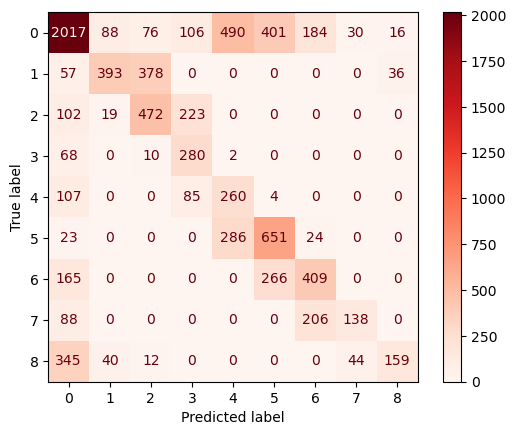

In [164]:
confusion_matrix = metrics.confusion_matrix(np.array(l_tot), np.array(p_tot))
cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix = confusion_matrix)
cm_display.plot(cmap='Reds')
plt.show()

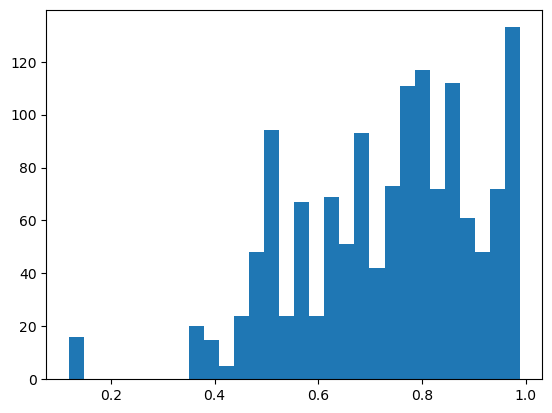

In [165]:
plt.hist(DStest['amplitude'].isel(time=ind_miss_0),30)
plt.show()

In [ ]:
# torch.save(best_mod.state_dict(),'./Categorical_SingleStream_MJO_CNN_GPU_testingACC.57.55.pt')
# torch.save(best_mod.to('cpu').state_dict(),'./Categorical_SingleStream_MJO_CNN_CPU_testingACC.57.55.pt')

In [46]:
momo_load = CategoricalCNN(input_shape=input_shape, num_classes=9)
momo_load.load_state_dict(torch.load('./Categorical_SingleStream_MJO_CNN_CPU_testingACC.57.55.pt'))
# Validation loop
device='cpu'
#to get probabilities: probabilities = F.softmax(outputs, dim=1)
test_dataset = SpatialDataset(DStest_norm_arr, DStest_Y)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

momo_load.eval()  # Set the model to evaluation mode
correct = 0
total = 0
l_tot = []
p_tot = []
prob_tot = []
countup = 0
probs_tot = torch.tensor([]) 

momo_load.to(device)

with torch.no_grad():  # In validation phase, we don't need to compute gradients
    for inputs, labels in test_loader:
        outputs = momo_load(inputs.to(device))
        _, predicted = torch.max(outputs.data, 1)
        probabilities = F.softmax(outputs, dim=1)
        predicted_prob, _ = torch.max(probabilities, 1)
        for ee,bb in enumerate(probabilities):
            if torch.max(bb)>0.3:
                predicted[ee]=predicted[ee]
            else:
                countup+=1
                predicted[ee]=0
        labels = labels.to(device)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

        l_tot+=list(np.array(labels.cpu()))
        p_tot+=list(np.array(predicted.cpu()))
        prob_tot+=list(np.array(predicted_prob.cpu()))
        probs_tot=torch.concat([probs_tot.cpu(),probabilities.cpu()],dim=0)
# Calculate and print validation accuracy
test_accuracy = 100 * correct / total
print(f"Testing Accuracy: {test_accuracy:.2f}%")
print(f"didnt classify: {countup} times'") 

Testing Accuracy: 57.55%
didnt classify: 2 times'


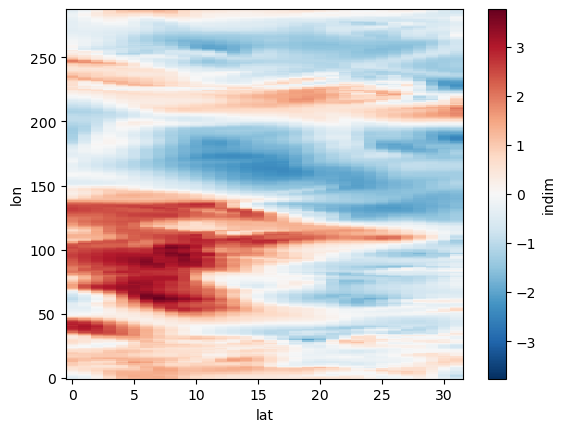

In [166]:
DS = xr.open_dataset('/glade/derecho/scratch/wchapman/f.e.FTORCHmjo_mean_exp001/run/Categorical_Input.nc')
DS['indim'].sel(var=1).squeeze().plot()

In [169]:
arr = np.array(DS['indim'])
device='cpu'

In [182]:
np.flip(arr.T.astype('float32'),axis=2).shape

(1, 6, 32, 288)

In [196]:
hiho =  arr.T.astype('float32')
hihi = np.flip(arr.T.astype('float32'),axis=3).copy()

In [198]:
x = momo_load(torch.tensor(hihi).to(device))

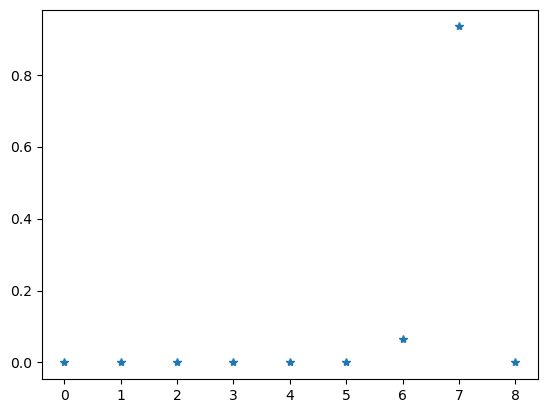

In [199]:
plt.plot(F.softmax(x, dim=1).detach().numpy().squeeze(),'*')

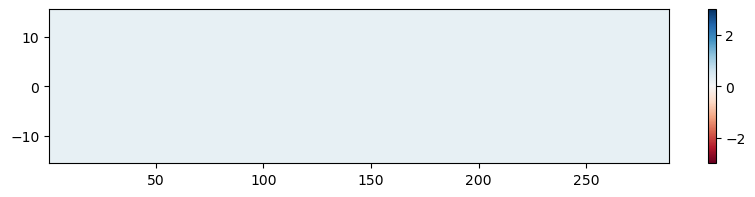

In [177]:
plt.figure(figsize=(10,2))
nnv = 0
vv = 5
plt.pcolor(np.linspace(1,288,288),np.linspace(-15,15,32),np.array(arr.T.astype('float32')[nnv,vv,:,:]),vmin=-3,vmax=3,cmap='RdBu')
plt.colorbar()
plt.show()

## Try an ANN

## Try Dropout 